In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import string
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from datetime import datetime
import math
import re
from rapidfuzz import process, fuzz

def clean_tokenize(review_string):
    """
    Clean and tokenize a review string by removing stopwords, punctuation,
    numbers, and empty strings, and then applying lemmatization.
    """    
    lower_string = review_string.lower()
    
    # Combine stopwords and punctuation into one list
    extended_stopwords = set(stopwords.words('english') + list(string.punctuation))

    # Compile a regular expression to match numbers
    number_pattern = re.compile(r'\d+')

    # Tokenize the review string
    tokens = word_tokenize(lower_string)

    # Filter out invalid tokens and convert to lowercase
    valid_tokens = [w for w in tokens if w not in extended_stopwords and not number_pattern.search(w)]

    # Initialize the WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()

    # Lemmatize the valid tokens
    clean_tokens = [lemmatizer.lemmatize(token) for token in valid_tokens]

    return clean_tokens

def count_vectorize(tokenized_doc):
    unique_words = set(tokenized_doc)
    word_dict = {word:0 for word in unique_words}
    for word in tokenized_doc:
        word_dict[word] += 1
    return word_dict

def remove_quotes(text):
    text = text.replace('"', '')
    return text

def remove_ordinal_suffix(day):
    return re.sub(r'\D', '', day)

def date_converter(date_str):
    date_list = date_str.split()        
    day = remove_ordinal_suffix(date_list[0])
    month = date_list[1]
    year = date_list[2]

    new_date_str = f"{day} {month} {year}"
    
    return new_date_str

def split_route(route):
    route_clean = str(route).lower().strip()
    if ' to ' in route_clean:
        if ' via ' in route_clean:
            direct_route = route_clean.split(' via ')
            locations = direct_route[0].split(' to ')
        else:
            locations = route_clean.split(' to ')
        origin = locations[0].strip()
        destination = locations[-1].strip()
    else:
        origin = None
        destination = None

    # Extracting the first (departing) and last (arriving) locations
    return origin, destination

# Function to clean and get unique values from a DataFrame column
def get_unique_col_values(df, col_names):
    unique_vals = pd.concat([df[col].str.lower().str.strip() for col in col_names]).unique()
    return unique_vals
    
def closest_match(query, choices):
    try:
        closest_match = process.extractOne(query, choices, scorer=fuzz.WRatio)
        match = closest_match[0]
        score = closest_match[1]
        return match, score
    except Exception:
        return (None, 0)

def try_map(word,mapper):
    try:
        return mapper[word]
    except:
        return None

def calculate_distance(origin, destination):
    try:
        origin_lat, origin_lon = [float(x) for x in origin.split(', ')]
        destination_lat, destination_lon = [float(x) for x in destination.split(', ')]
        # Calculating haversine distance
        origin_lon, origin_lat, destination_lon, destination_lat = map(math.radians, [origin_lon, origin_lat, destination_lon, destination_lat])
        dlon = destination_lon - origin_lon
        dlat = destination_lat - origin_lat
        a = math.sin(dlat/2)**2 + math.cos(origin_lat) * math.cos(destination_lat) * math.sin(dlon/2)**2
        c = 2 * math.asin(math.sqrt(a))
        r = 6371
        return c * r
    except:
        return None

In [2]:
# Clean & Prep new df

# Load the original dataset
old_df = pd.read_csv('data/Airline_review.csv').iloc[:, 1:]

# Initialize a new DataFrame
df = pd.DataFrame()

# Process and add the review titles after removing quotes
df['review_title']= old_df['Review_Title'].map(remove_quotes)

# Combine review titles and content, then clean and tokenize
combined_text = old_df['Review_Title'].apply(remove_quotes) + ' ' + old_df['Review']
df['tokens'] = combined_text.apply(clean_tokenize)

# Join the tokens back into a cleaned review
df['clean_review'] = df['tokens'].apply(lambda x: ' '.join(x))

# Convert review and flight dates to datetime format
df['date_review'] = pd.to_datetime(old_df['Review Date'].apply(date_converter), format='%d %B %Y')
df['date_flown'] = pd.to_datetime(old_df['Date Flown'], format='%B %Y')

# Splitting Route into origin and destination
df['origin'], df['destination'] = zip(*old_df['Route'].apply(split_route))

In [3]:
# Importing and cleaning the airport codes data
codes_df = pd.read_csv('data/airport_codes.csv', sep=';')
codes_df = codes_df.rename(columns={
    'Airport Code': 'code',
    'Airport Name': 'airport',
    'City Name': 'city'
}).apply(lambda x: x.str.lower().str.strip() if x.name in ['code', 'airport', 'city'] else x)
codes_df = codes_df[['code', 'airport', 'city', 'coordinates']]

In [4]:
# Getting all unique airport codes, airport names and city names
unique_codes = get_unique_col_values(codes_df, ['code', 'airport', 'city'])

# Getting all unique origins and destinations
unique_originals = get_unique_col_values(df, ['origin', 'destination'])

# Finding the closest match to help merge dataframes
matches = []
scores = []
for word in unique_originals:
    match, score = closest_match(word,unique_codes)
    matches.append(match)
    scores.append(score)
score_df = pd.DataFrame({'word': unique_originals, 'match': matches, 'score': scores})

# Filtering out rows with match scores of less than 80
score_df = score_df.loc[score_df['score'] >= 80]

# Creating a dictionary to map coordinates onto matched values
melted_df = codes_df.melt(id_vars='coordinates', value_vars=['code', 'airport', 'city'], value_name='Key').drop('variable', axis=1)
result_dict = dict(zip(melted_df['Key'], melted_df['coordinates']))

# Adding coordinates to score_Df
score_df['coordinates'] = score_df['match'].apply(lambda x: try_map(x,result_dict))

# Enrich the original DataFrame with origin and destination coordinates
df['origin_coordinates'] = pd.merge(df, score_df, left_on= 'origin',right_on='word', how='left')['coordinates']
df['destination_coordinates'] = pd.merge(df, score_df, left_on= 'destination',right_on='word', how='left')['coordinates']

# Mapping city names to origin and destination based on coordinates
df['origin_city'] = pd.merge(df, codes_df, left_on= 'origin_coordinates',right_on='coordinates', how='left')['city']
df['destination_city'] = pd.merge(df, codes_df, left_on= 'destination_coordinates',right_on='coordinates', how='left')['city']

# Calculate distances
df['distance'] = df.apply(lambda row: calculate_distance(row['origin_coordinates'], row['destination_coordinates']), axis=1)

df.drop(['origin_coordinates', 'destination_coordinates','origin','destination','review_title'], axis=1, inplace=True)

In [17]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

def analyze_categorical_association(VariableA, VariableB, df):
    # Create a contingency table
    contingency_table = pd.crosstab(df[VariableA], df[VariableB])
    
    # Perform the Chi-Square Test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    # Calculate Cramér's V for the association strength
    n = df.shape[0]  # Total number of observations
    k1 = len(df[VariableA].unique())  # Number of categories in VariableA
    k2 = len(df[VariableB].unique())  # Number of categories in VariableB (should be 2 for a binary variable)
    cramers_v = np.sqrt(chi2 / (n * min(k1 - 1, k2 - 1)))
    print(VariableA)
    print(f"Cramér's V: {cramers_v}")
    print('')

In [19]:
for i in ['Type Of Traveller', 'Seat Type']:
    analyze_categorical_association(i, 'Recommended', old_df)

Type Of Traveller
Cramér's V: 0.07998553295337242

Seat Type
Cramér's V: 0.13566742418667638



['Airline Name', lower
 'Overall_Rating', Change to int, impute n to median
 'Verified',
 'Type Of Traveller', drop. there doesn't appear to be a correlation and i don't want to delete 4,000 rows
 'Seat Type',cat ?? Not sure
 
 'Seat Comfort', convert to int, impute median
 'Cabin Staff Service', convert to int, impute median
 'Food & Beverages', convert to int, impute median
 'Ground Service', convert to int, impute median
 'Inflight Entertainment', drop
 'Wifi & Connectivity', drop
 'Value For Money', convert to int, impute median
 'Recommended']

In [24]:
old_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Airline Name            23171 non-null  object 
 1   Overall_Rating          23171 non-null  object 
 2   Review_Title            23171 non-null  object 
 3   Review Date             23171 non-null  object 
 4   Verified                23171 non-null  bool   
 5   Review                  23171 non-null  object 
 6   Aircraft                7129 non-null   object 
 7   Type Of Traveller       19433 non-null  object 
 8   Seat Type               22075 non-null  object 
 9   Route                   19343 non-null  object 
 10  Date Flown              19417 non-null  object 
 11  Seat Comfort            19016 non-null  float64
 12  Cabin Staff Service     18911 non-null  float64
 13  Food & Beverages        14500 non-null  float64
 14  Ground Service          18378 non-null

In [21]:
test = old_df.dropna(subset=['Date Flown'])

In [24]:
for i in old_df.columns:
    before = len(old_df[i].dropna()) 
    after = len(test[i].dropna())
    print(i)
    print(f'Difference: {before-after}')
    print('')

Airline Name
Difference: 3754

Overall_Rating
Difference: 3754

Review_Title
Difference: 3754

Review Date
Difference: 3754

Verified
Difference: 3754

Review
Difference: 3754

Aircraft
Difference: 7

Type Of Traveller
Difference: 17

Seat Type
Difference: 2661

Route
Difference: 12

Date Flown
Difference: 0

Seat Comfort
Difference: 1404

Cabin Staff Service
Difference: 1404

Food & Beverages
Difference: 1398

Ground Service
Difference: 12

Inflight Entertainment
Difference: 1362

Wifi & Connectivity
Difference: 0

Value For Money
Difference: 2690

Recommended
Difference: 3754



In [23]:
len(test['Aircraft'].dropna())

7122

In [32]:
old_df['null_count'] = old_df.isnull().sum(axis=1)

In [49]:
old_df['null_count'].value_counts().sort_index()

null_count
0     1667
1     5979
2     3932
3     2975
4     2962
5      165
6     2100
7     1013
8       27
9        2
10    1263
11      32
12    1054
Name: count, dtype: int64

In [39]:
len(old_df.loc[old_df['null_count']==9])

2349

In [46]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


<Axes: >

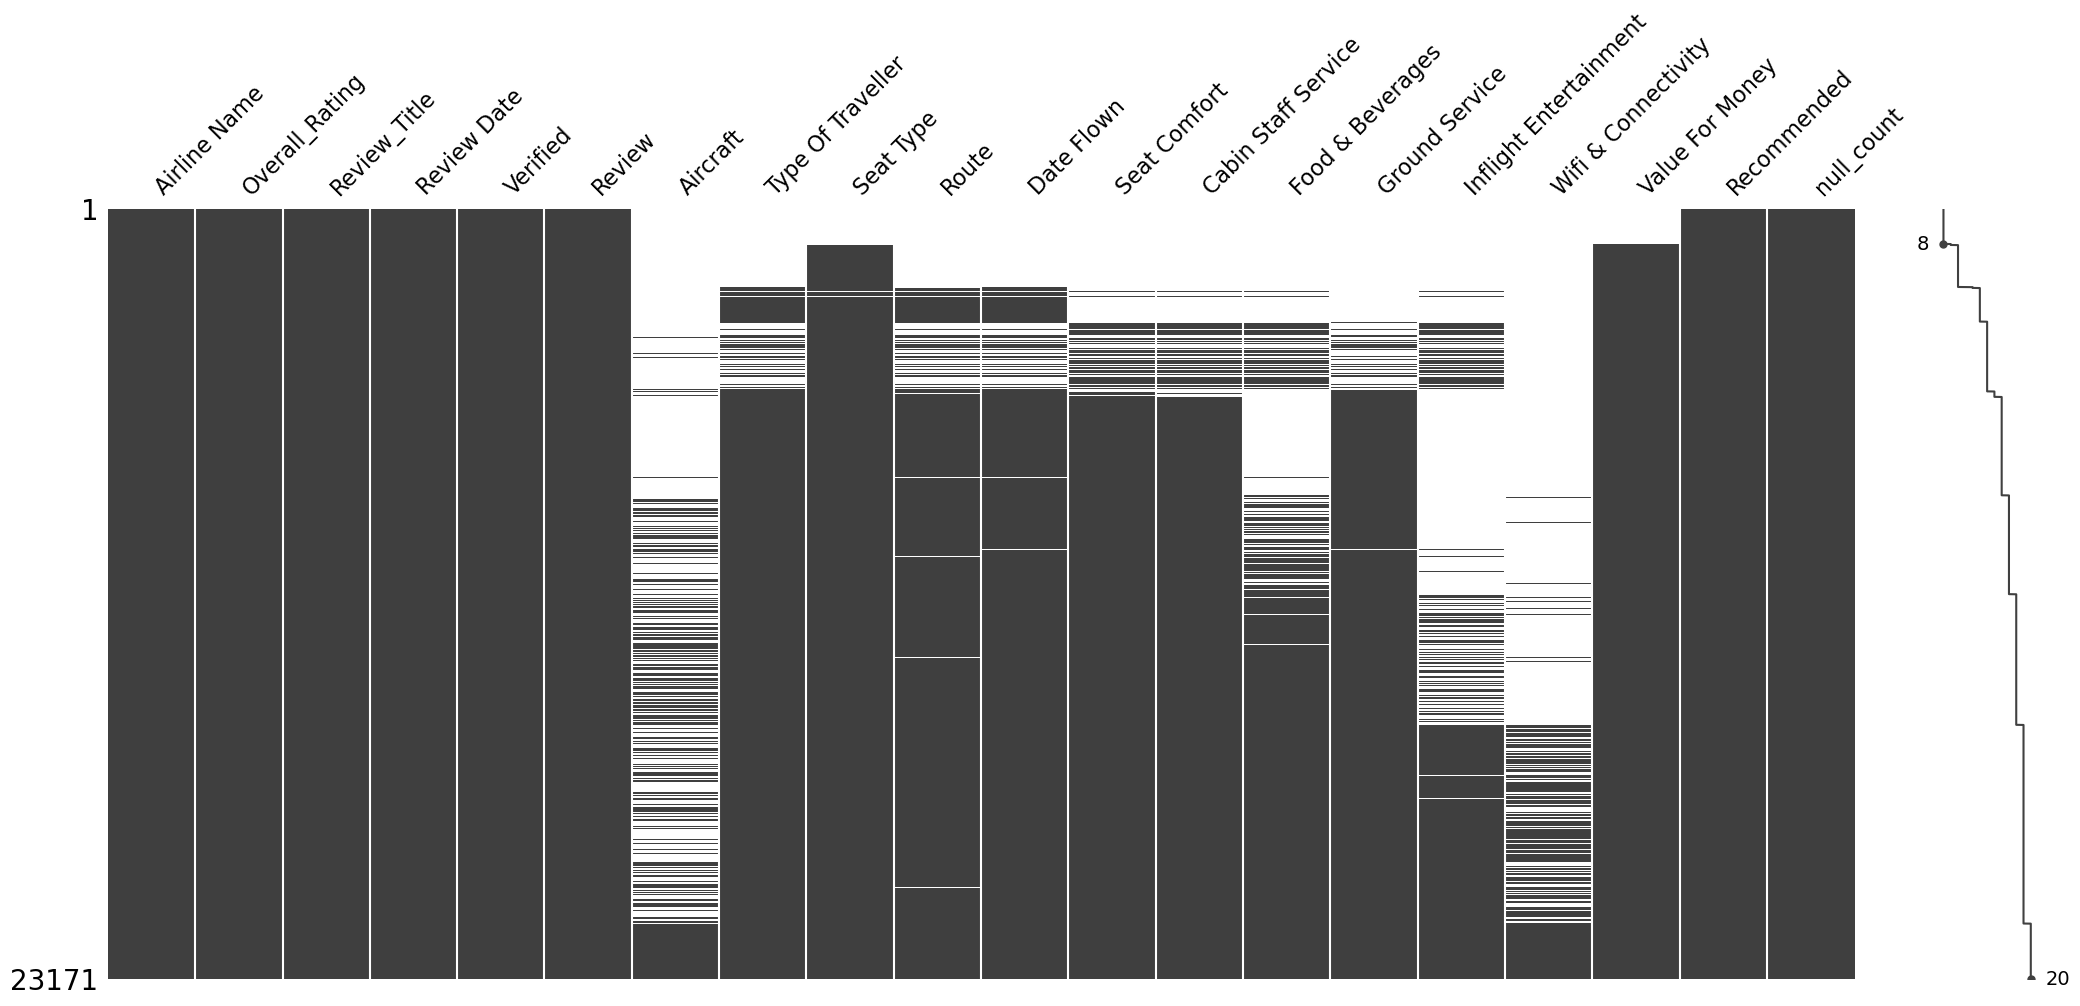

In [47]:
import missingno as msno
import pandas as pd
import numpy as np

# Visualizing missing values with a heatmap
msno.matrix(null_df)
# dropping Aircraft, Food & Beverages, inflight entertainment, wifi connectivity
# dropping all rows with 

In [57]:
null_df_dropped = null_df.drop(['Aircraft','Food & Beverages','Inflight Entertainment',
       'Wifi & Connectivity','Type Of Traveller', 'Seat Type'], axis= 1).copy()

<Axes: >

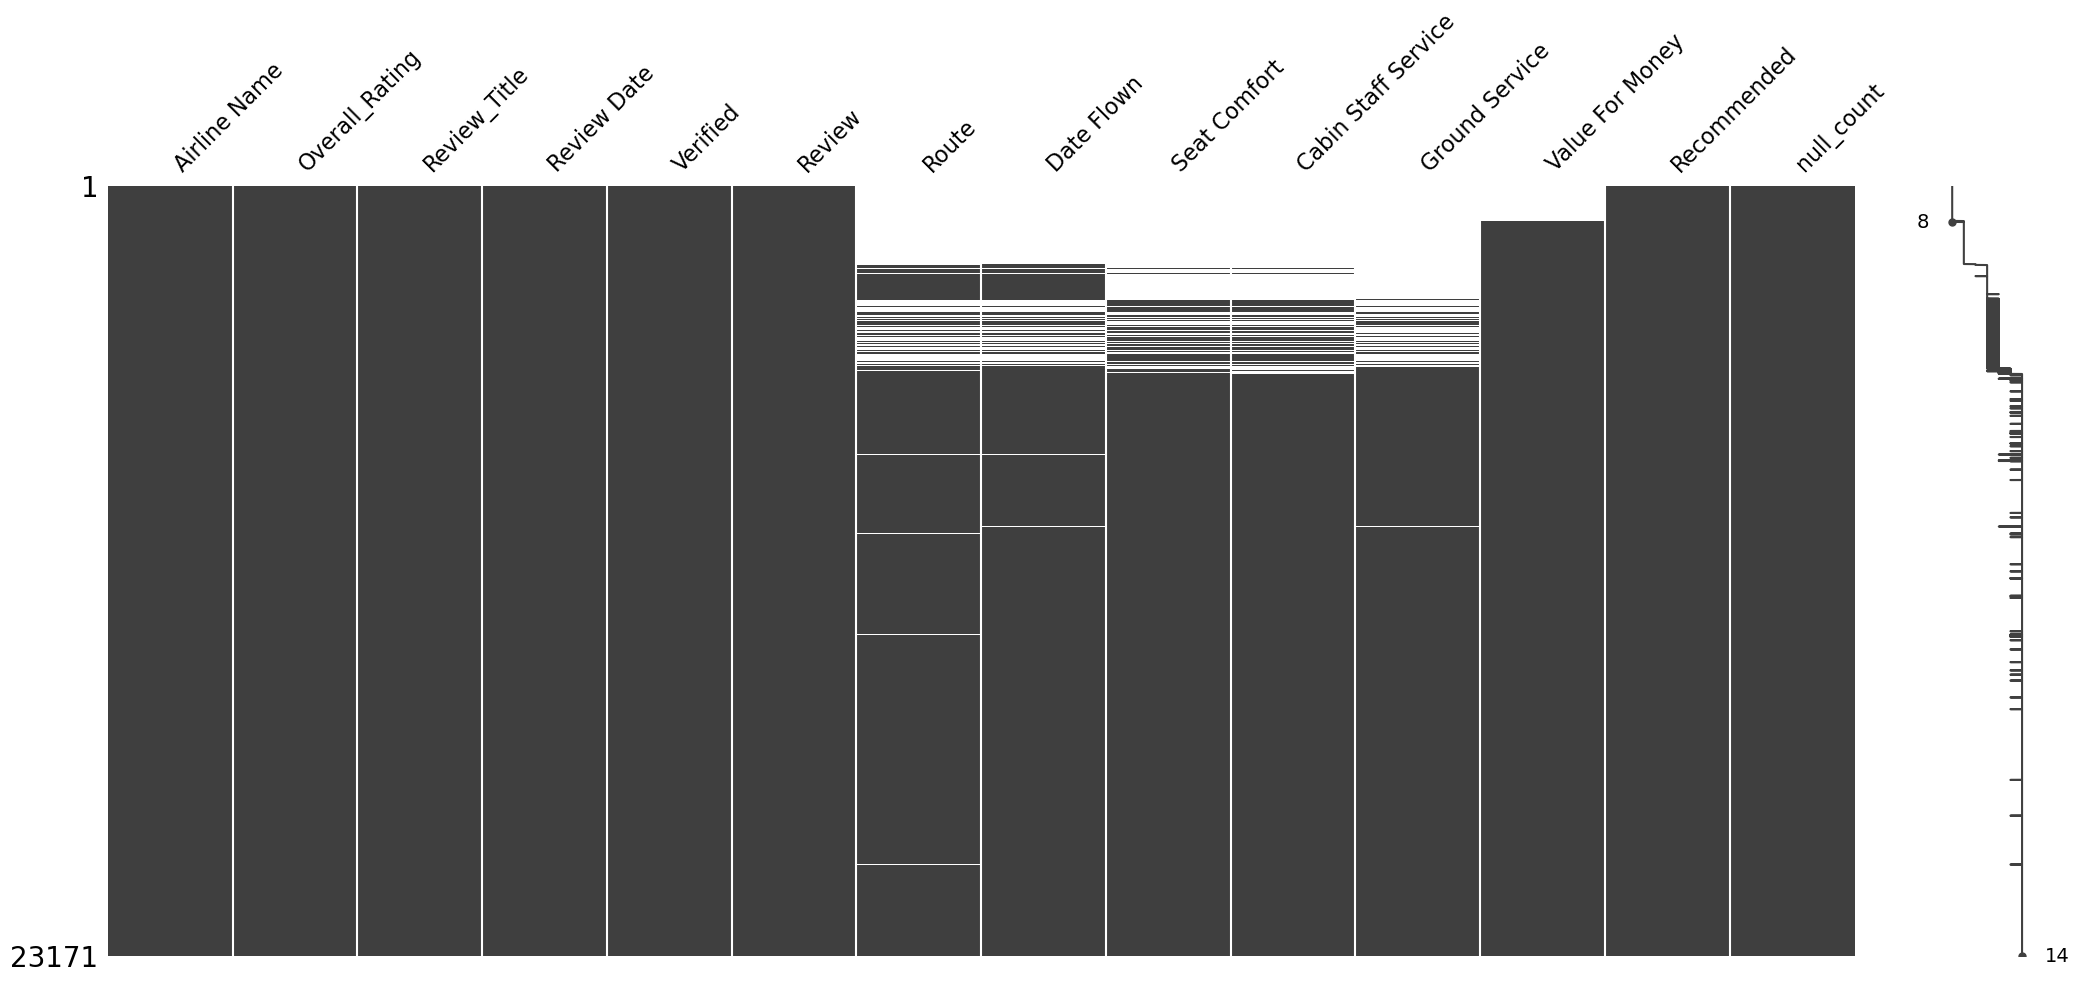

In [54]:
msno.matrix(null_df_dropped)

In [50]:
null_df.columns

Index(['Airline Name', 'Overall_Rating', 'Review_Title', 'Review Date',
       'Verified', 'Review', 'Aircraft', 'Type Of Traveller', 'Seat Type',
       'Route', 'Date Flown', 'Seat Comfort', 'Cabin Staff Service',
       'Food & Beverages', 'Ground Service', 'Inflight Entertainment',
       'Wifi & Connectivity', 'Value For Money', 'Recommended', 'null_count'],
      dtype='object')

In [59]:
for i in ['Seat Comfort', 'Cabin Staff Service','Ground Service','Value For Money']:
    median_score = null_df_dropped[i].median()
    null_df_dropped.fillna({i: median_score}, inplace=True)

<Axes: >

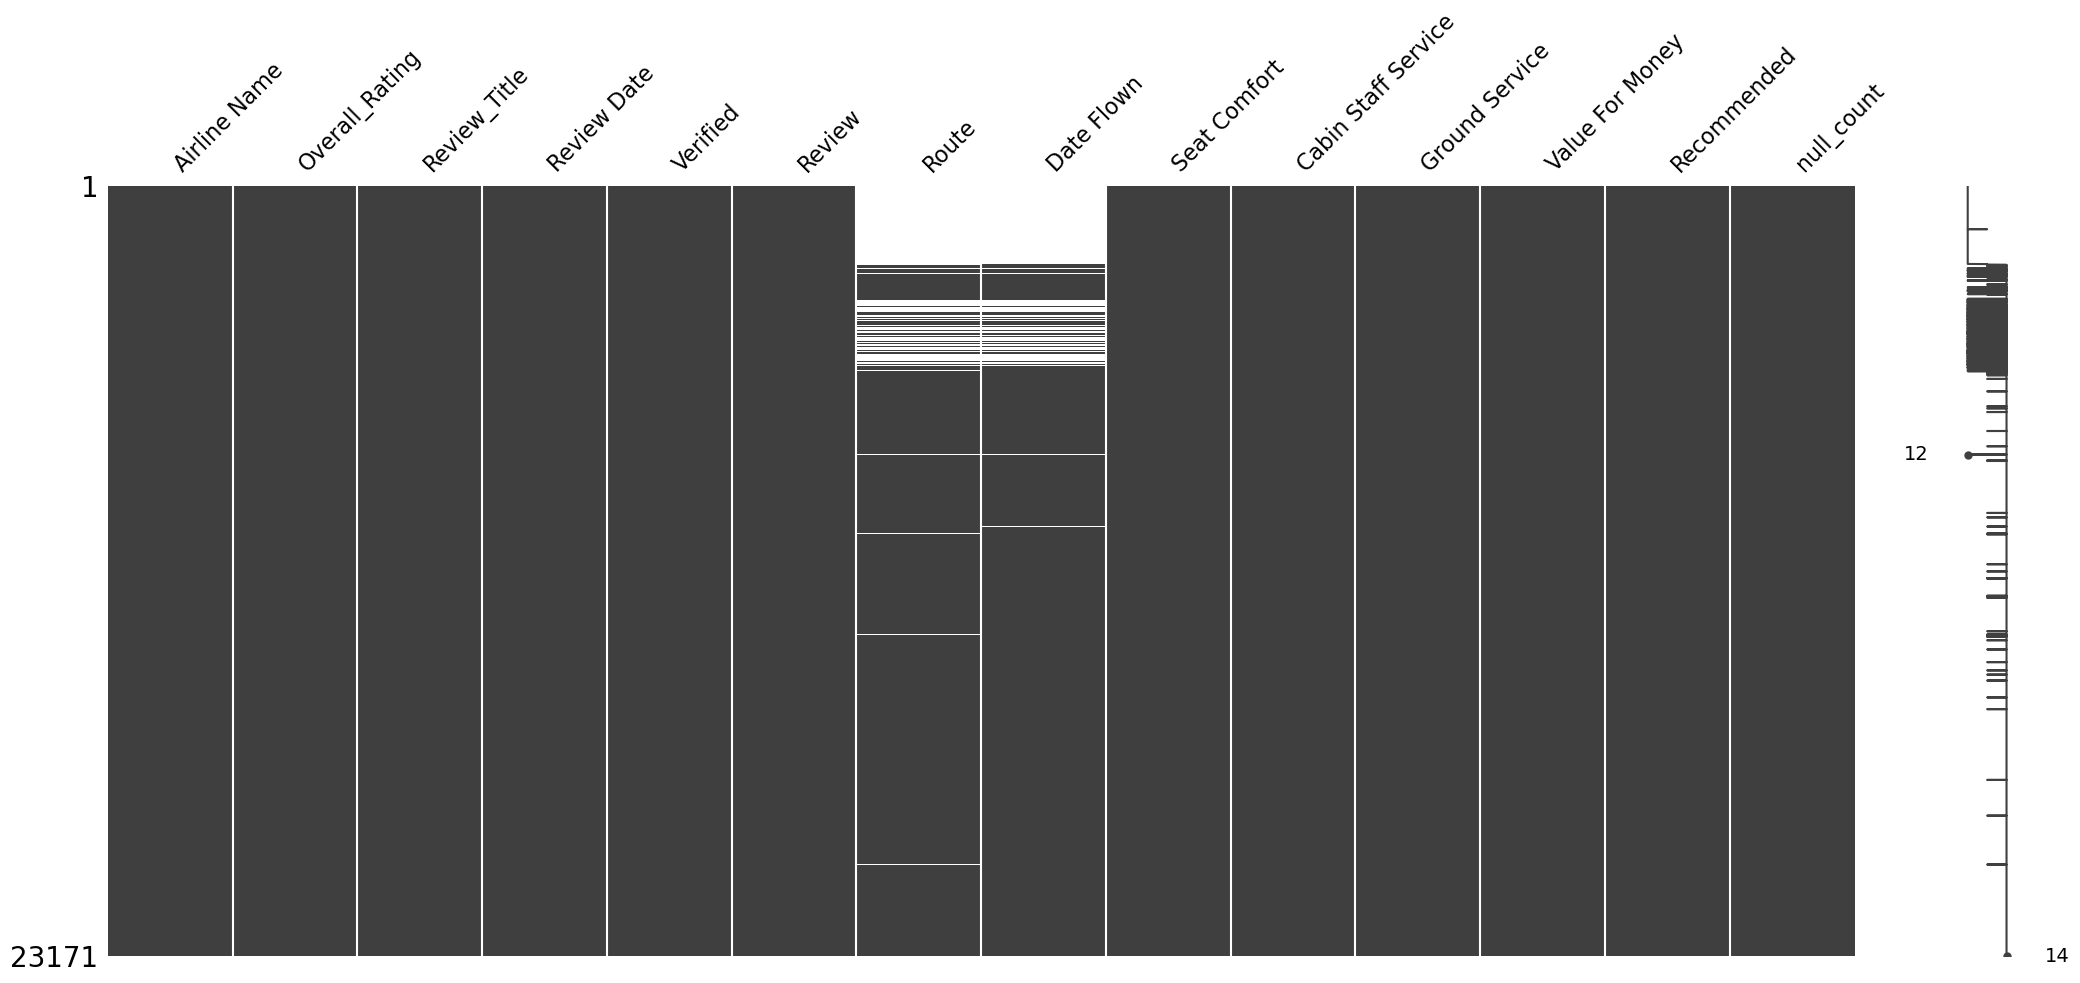

In [60]:
msno.matrix(null_df_dropped)

In [61]:
df.head()

,tokens,clean_review,date_review,date_flown,origin_city,destination_city,distance
0,"[pretty, decent, airline, moroni, moheli, turn...",pretty decent airline moroni moheli turned pre...,2019-11-11,2019-11-01,moroni,moheli,57.287139
1,"[good, airline, moroni, anjouan, small, airlin...",good airline moroni anjouan small airline tick...,2019-06-25,2019-06-01,moroni,anjouan,131.296009
2,"[flight, fortunately, short, anjouan, dzaoudzi...",flight fortunately short anjouan dzaoudzi smal...,2019-06-25,2019-06-01,anjouan,dzaoudzi,118.372548
3,"[never, fly, adria, please, favor, fly, adria,...",never fly adria please favor fly adria route m...,2019-09-28,2019-09-01,frankfurt,prishtina,1129.458408
4,"[ruined, last, day, holiday, book, flight, air...",ruined last day holiday book flight airline fr...,2019-09-24,2019-09-01,frankfurt,amsterdam,1752.353708


In [62]:
df['date_diff'] = df['date_review'] - df['date_flown']

In [76]:
df['date_diff'] = df['date_diff'].dt.days

In [85]:
from datetime import date, timedelta

median_days_after = df['date_diff'].median()
duration = timedelta(days=median_days_after)

In [86]:
df['date_flown'] = df['date_flown'].fillna(df['date_review'] - duration)

In [82]:
df[df['date_flown'].isna()].index

Index([   42,    43,    44,    45,    46,    47,    48,    49,    50,    51,
       ...
       23105, 23106, 23107, 23108, 23109, 23110, 23111, 23112, 23113, 23114],
      dtype='int64', length=3754)

In [88]:
df.iloc[[42,    43,    44,    45,    46,    47,    48,    49,    50,    51,],:]

,tokens,clean_review,date_review,date_flown,origin_city,destination_city,distance,date_diff
42,"[adria, airway, customer, review, outbound, fl...",adria airway customer review outbound flight f...,2015-04-10,2015-03-18,skopje,ljubljana,NaN,NaN
43,"[adria, airway, customer, review, two, short, ...",adria airway customer review two short hop zrh...,2015-01-05,2014-12-13,frankfurt,brussels,NaN,NaN
44,"[adria, airway, customer, review, flew, zurich...",adria airway customer review flew zurich-ljubl...,2014-09-14,2014-08-22,frankfurt,ljubljana,NaN,NaN
45,"[adria, airway, customer, review, adria, serf,...",adria airway customer review adria serf min fl...,2014-09-06,2014-08-14,ljubljana,NaN,NaN,NaN
46,"[adria, airway, customer, review, waw-skj, eco...",adria airway customer review waw-skj economy f...,2014-06-16,2014-05-24,manchester,NaN,NaN,NaN
47,"[adria, airway, customer, review, sarajevo-fra...",adria airway customer review sarajevo-frankfur...,2014-06-08,2014-05-16,NaN,NaN,NaN,NaN
48,"[adria, airway, customer, review, flight, pari...",adria airway customer review flight paris sara...,2014-06-01,2014-05-09,NaN,NaN,NaN,NaN
49,"[adria, airway, customer, review, lju, fra, ba...",adria airway customer review lju fra back flig...,2014-05-10,2014-04-17,NaN,NaN,NaN,NaN
50,"[adria, airway, customer, review, ljubljana, m...",adria airway customer review ljubljana munich ...,2014-01-13,2013-12-21,NaN,NaN,NaN,NaN
51,"[adria, airway, customer, review, flight, lju,...",adria airway customer review flight lju zrh ba...,2014-01-06,2013-12-14,NaN,NaN,NaN,NaN


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   tokens            23171 non-null  object        
 1   clean_review      23171 non-null  object        
 2   date_review       23171 non-null  datetime64[ns]
 3   date_flown        23171 non-null  datetime64[ns]
 4   origin_city       19592 non-null  object        
 5   destination_city  19517 non-null  object        
 6   distance          19295 non-null  float64       
 7   date_diff         19417 non-null  float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 1.4+ MB


In [93]:
median_score = df['distance'].median()
df.fillna({'distance': median_score}, inplace=True)
df.drop('date_diff',axis=1, inplace=True)
